In [2]:
library(tidyverse)

library(ranger)
library(h2o)

In [3]:
ames <- ames <- AmesHousing::make_ames()
index <- sample(1:dim(ames)[1], 0.7*dim(ames)[1])
ames_train <- ames[index,]
ames_test <- ames[-index,]

## 랜덤포레스트
- 예측 성능을 향상시키기위해 상관관계가 없는 트리의 대규모 컬렉션
- 비교적 적은 초매개변수로 우수한 예측 성능

### 배깅의 확장
#### - 랜덤포레스트는 트리 성장과정에 더 많은 무작위성을 주임하여 트리상관관계를 줄임
- 트리를 성장시키는 동안 **분할 변수의 랜덤화**
- 회귀의 경우 mtry = p / 3
- 분류의 경우 mtry = sqrt(p)
- 훈련할 부트스트랩 샘플과 각 분할에서 사용할 변수를 무작위로 선택하기 대문에, 더 다양한 트리세트가 생성되어, 상관관계가 줄어들고 예측력이 증가

1. 주어진 훈련 데이터 세트 
2. 구축할 트리 수 선택(n_trees) 
3. i = 1에서 n_trees까지 
4. | 원본 데이터의 부트스트랩 샘플 생성 
5. | 부트스트랩된 데이터로 회귀/분류 트리 성장 
6. | 각 분할에 대해 
7. | | 모든 p 변수에서 무작위로 m_try 변수 선택 
8. | | m_try 중에서 가장 좋은 변수/분할점을 선택.
9. | | 노드를 두 개의 자식 노드로 분할 
10. | 끝
11. | 일반적인 트리 모델 정지기준을 사용하여 언제 나무가 완성되는지 결정 (하지만 가지치기는 안함) 
12. 끝 
13. 트리 출력 앙상블

### ```ranger::ranger()```
- ```mtry``` : 트리 생성에 사용할 변수의 수
- ```respect.unordered.factors = "order"``` : 이것은 정렬되지 않은 범주형 변수를 순서로 정렬

In [9]:
(n_features <- length(setdiff(names(ames_train), "Sale_Price")))

[1] 80

In [5]:
ames_rf1 <- ranger(
  Sale_Price ~ ., 
  data = ames_train,
  mtry = floor(n_features / 3),
  respect.unordered.factors = "order",
  seed = 123
)

In [6]:
attributes(ames_rf1)

$names
 [1] "predictions"               "num.trees"                
 [3] "num.independent.variables" "mtry"                     
 [5] "min.node.size"             "prediction.error"         
 [7] "forest"                    "splitrule"                
 [9] "treetype"                  "r.squared"                
[11] "call"                      "importance.mode"          
[13] "num.samples"               "replace"                  

$class
[1] "ranger"

In [7]:
ames_rf1

Ranger result

Call:
 ranger(Sale_Price ~ ., data = ames_train, mtry = floor(n_features/3),      respect.unordered.factors = "order", seed = 123) 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      2051 
Number of independent variables:  80 
Mtry:                             26 
Target node size:                 5 
Variable importance mode:         none 
Splitrule:                        variance 
OOB prediction error (MSE):       644747484 
R squared (OOB):                  0.8985528 

In [8]:
(default_rmse <- sqrt(ames_rf1$prediction.error))

[1] 25391.88

### 튜닝
#### 초매개변수
1. 나무의 수
2. mtry
3. 각 트리의 복잡성
4. 샘플링방식
5. 트리생성에 사용할 분할규칙

### 1. 나무의 수
- 오류율을 안정화하려면 트리수가 충분히 커야함
- p X 10으로 시작
- mtry나 노드 크기에 따라 더 많거나 적은 수의 트리가 필요함
- 많은 트리는 더 강력하고 안정한 오류추정값과 변수 중요도를 제공

### 2. mtry
- 분할 변수 무작위의 기능을 제어
- 낮은 트리 상관관계와 합리적인 예측강도의 균형을 맞춤
- 회귀의 경우 mtry = p / 3
- 분류의 경우 mtry = sqrt(p)

### 3. 트리의 복잡성
- **노드 크기, 최대 깊이, 최대 터미널 노드 수, 추가분할 허용 여부**
- 회귀의 경우 : 5
- 분류의 경우 : 1
- 데이터에 노이즈가 많은 경우 노드 크기를 증가 (트리 깊이 및 복잡성 감소)하여 성능을 향상

### 4. 샘플링 방식
- 샘플링 크기와 복원추출 여부를 모두 조정 가능
- 샘플링 크기를 줄이면 트리가 다양해지고, 트리간 상관관게가 낮아짐 => 긍정적 영향
- **범주의 수가 많은 범주형 변수의 경우, 복원추출은 변수 분할에 편향이 발생 가능**
- **균형이 맞지 않는 범주가 있는 경우, 비복원 추출을 사용하면 편향이 감소**

### 5. 분할규칙
- 분류의 경우 : 지니 불순도
- 히귀의 경우 : SSE

### 튜닝

In [9]:
hyper_grid <- expand.grid(
    mtry = floor(n_features * c(0.05, 0.15, 0.25, 0.333, 0.4)), # 사용할 변수 수
    min.node.size = c(1, 3, 5, 10), # 노드 크기 (정지규칙)
    replace = c(TRUE, FALSE), # 복원추출, 비복원추출
    sample.fraction = c(.5, .63, .8), # # 추출비율
    rmse = NA
)
hyper_grid %>% head
dim(hyper_grid)

,mtry,min.node.size,replace,sample.fraction,rmse
,<dbl>,<dbl>,<lgl>,<dbl>,<lgl>
1,4,1,TRUE,0.5,NA
2,12,1,TRUE,0.5,NA
3,20,1,TRUE,0.5,NA
4,26,1,TRUE,0.5,NA
5,32,1,TRUE,0.5,NA
6,4,3,TRUE,0.5,NA


[1] 120   5

#### 120개의 설정 조합중 그리드서치

In [10]:
for(i in seq_len(nrow(hyper_grid))) {
  fit <- ranger(
    formula         = Sale_Price ~ ., 
    data            = ames_train, 
    num.trees       = n_features * 10,
    mtry            = hyper_grid$mtry[i],
    min.node.size   = hyper_grid$min.node.size[i],
    replace         = hyper_grid$replace[i],
    sample.fraction = hyper_grid$sample.fraction[i],
    verbose         = FALSE,
    seed            = 123,
    respect.unordered.factors = 'order',
  )
  hyper_grid$rmse[i] <- sqrt(fit$prediction.error)
}

In [11]:
default_rmse

[1] 25391.88

In [12]:
hyper_grid %>%
  arrange(rmse) %>%
  mutate(perc_gain = (default_rmse - rmse) / default_rmse * 100) %>%
  head(10)

,mtry,min.node.size,replace,sample.fraction,rmse,perc_gain
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
1,20,1,FALSE,0.8,24657.85,2.890790
2,20,5,FALSE,0.8,24796.21,2.345897
3,32,1,FALSE,0.8,24808.84,2.296153
4,20,3,FALSE,0.8,24809.02,2.295465
5,32,5,FALSE,0.8,24840.40,2.171855
6,32,3,FALSE,0.8,24892.08,1.968346
7,26,1,FALSE,0.8,24938.06,1.787277
8,12,1,FALSE,0.8,24985.82,1.599166
9,20,10,FALSE,0.8,24998.93,1.547529


#### 0.8의 비율로 비복원추출(replace = FALSE)을 하는것이 가장 높은 성능을 보임

### 예측
- 그리드서치된 초매개변수들을 기반으로 최종모형 생성

### ```predict()``` 
- ```object``` : ranger 모형
- ```data``` : test데이터

In [25]:
ames_rf_g <- ranger(
    Sale_Price ~ ., 
    data = ames_train,
    mtry = 20,
    num.trees = n_features * 10,
    min.node.size = hyper_grid$min.node.size[i],
    replace = FALSE,
    sample.fraction = 0.8,
    respect.unordered.factors = "order",
    seed = 123
)

In [27]:
ames_rf_g

Ranger result

Call:
 ranger(Sale_Price ~ ., data = ames_train, mtry = 20, num.trees = n_features *      10, min.node.size = hyper_grid$min.node.size[i], replace = FALSE,      sample.fraction = 0.8, respect.unordered.factors = "order",      seed = 123) 

Type:                             Regression 
Number of trees:                  800 
Sample size:                      2051 
Number of independent variables:  80 
Mtry:                             20 
Target node size:                 5 
Variable importance mode:         none 
Splitrule:                        variance 
OOB prediction error (MSE):       614852076 
R squared (OOB):                  0.9032567 

In [36]:
pred <- predict(object = ames_rf_g, data = ames_test)

In [33]:
attributes(pred)

$names
[1] "predictions"               "num.trees"                
[3] "num.independent.variables" "num.samples"              
[5] "treetype"                 

$class
[1] "ranger.prediction"

In [37]:
pred$predictions %>% head
ames_test$Sale_Price %>% head

[1] 237224.9 172217.4 175214.0 386755.7 117938.1 215751.6

[1] 244000 185000 180400 538000 141000 210000

In [38]:
mse <- mean((ames_test$Sale_Price - pred$predictions)^2) 
rmse <- sqrt(mse)
mse ; rmse

[1] 563403712

[1] 23736.13

## h2o

#### 1. h2o세션 시작
### ```h2o.no_progress()```
### ```h2o.init()```

In [4]:
h2o.no_progress()

In [5]:
h2o.init(max_mem_size = "5g")


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\APF_TE~1\AppData\Local\Temp\RtmpAbD1qt\file48447446196/h2o_apf_temp_admin_started_from_r.out
    C:\Users\APF_TE~1\AppData\Local\Temp\RtmpAbD1qt\file4845f28e/h2o_apf_temp_admin_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         12 seconds 117 milliseconds 
    H2O cluster timezone:       Asia/Seoul 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.0.4 
    H2O cluster version age:    7 days, 10 hours and 45 minutes  
    H2O cluster name:           H2O_started_from_R_apf_temp_admin_zni088 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.44 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
 

#### 2. h2o 객체 변환
### ```as.h2o()```

In [6]:
train_h2o <- as.h2o(ames_train)
test_h2o <- as.h2o(ames_test)

response <- "Sale_Price"
predictors <- setdiff(colnames(ames_train), response)

### ```h2o.randomForest()```

In [ ]:
h2o_rf1 <- h2o.randomForest(
    x = predictors, 
    y = response,
    training_frame = train_h2o, 
    ntrees = n_features * 10,
    seed = 123
)

In [19]:
h2o_rf1

Model Details:

H2ORegressionModel: drf
Model ID:  DRF_model_R_1649257930169_1 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1             800                      800            12342446        19
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        20   19.99750       1121       1290  1222.83500


H2ORegressionMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  628652661
RMSE:  25072.95
MAE:  15191.58
RMSLE:  0.1344573
Mean Residual Deviance :  628652661





#### 그리드서치
- 파라미터 그리드가 list여야됨

### ```h2o.grid()```

In [22]:
hyper_grid <- list(
    mtries = floor(n_features * c(.05, .15, .25, .333, .4)),
    min_rows = c(1, 3, 5, 10),
    max_depth = c(10, 20, 30),
    sample_rate = c(.55, .632, .7, .8)
)

#### 조기종료 옵션
- 마지막 10개 모델 중 어느 것도 그 이전의 최상의 모델과 비교하여 MSE에서 0.1%개선을 달성하지 못하면 조기 종료
- 계속해서 개선사항을 찾으면 60 X 10초후에 그리드서치를 중지

In [23]:
search_criteria <- list(
    strategy = "RandomDiscrete",
    stopping_metric = "mse",
    stopping_tolerance = 0.001,
    stopping_rounds = 10,
    max_runtime_secs = 60 * 10
)

#### h2o.grid() 
- 마지막 10개 트리에서 전체 OOB 오류가 0.05%이상 개선되지 않은 경우 개별 랜덤포레스트 모델의 성장을 중지

In [24]:
random_grid <- h2o.grid(
  algorithm = "randomForest",
  grid_id = "rf_random_grid",
  x = predictors, 
  y = response, 
  training_frame = train_h2o,
  hyper_params = hyper_grid,
  ntrees = n_features * 10,
  seed = 123,
  stopping_metric = "RMSE",   
  stopping_rounds = 10,            
  stopping_tolerance = 0.005,     
  search_criteria = search_criteria
)

#### 총 32개의 모델을 평가

In [42]:
random_grid_perf <- h2o.getGrid(
  grid_id = "rf_random_grid", 
  sort_by = "mse", 
  decreasing = FALSE
)
random_grid_perf

H2O Grid Details

Grid ID: rf_random_grid 
Used hyper parameters: 
  -  max_depth 
  -  min_rows 
  -  mtries 
  -  sample_rate 
Number of models: 32 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing mse
  max_depth min_rows   mtries sample_rate               model_ids
1  30.00000  1.00000 20.00000     0.70000 rf_random_grid_model_24
2  20.00000  1.00000 20.00000     0.70000 rf_random_grid_model_18
3  20.00000  1.00000 32.00000     0.80000 rf_random_grid_model_32
4  30.00000  1.00000 26.00000     0.63200 rf_random_grid_model_28
5  30.00000  3.00000 26.00000     0.80000 rf_random_grid_model_10
              mse
1 618831638.44738
2 619871989.94588
3 623205415.06437
4 627774216.53959
5 631286427.23519

---
   max_depth min_rows  mtries sample_rate               model_ids
27  20.00000  5.00000 4.00000     0.80000  rf_random_grid_model_2
28  10.00000  5.00000 4.00000     0.55000  rf_random_grid_model_5
29  30.00000 10.00000 4.00000     0.80000 rf_random_gri

In [73]:
random_grid_perf@summary_table %>% head

,max_depth,min_rows,mtries,sample_rate,model_ids,mse
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,30,1,20,0.700,rf_random_grid_model_24,618831638
2,20,1,20,0.700,rf_random_grid_model_18,619871990
3,20,1,32,0.800,rf_random_grid_model_32,623205415
4,30,1,26,0.632,rf_random_grid_model_28,627774217
5,30,3,26,0.800,rf_random_grid_model_10,631286427
6,30,1,12,0.632,rf_random_grid_model_3,650548596


In [75]:
bestmodel <- h2o.getModel(random_grid_perf@model_ids[[1]])

#### - ```max_depth``` = 30, ```min_rows``` = 1, ```mtries``` = 20, ```sample_rate``` = 0.7이 가장 가장 낮은 mse를 가지는, 최적의 모델

In [76]:
h2o.r2(bestmodel)

[1] 0.902583

### ```h2o.performance()```
- ```model``` : h2o모델
- ```newdata``` : test데이터

In [77]:
perf <- h2o.performance(model = bestmodel, newdata = test_h2o)

In [78]:
perf

H2ORegressionMetrics: drf

MSE:  590003385
RMSE:  24289.99
MAE:  14993.2
RMSLE:  0.1354787
Mean Residual Deviance :  590003385


In [79]:
h2o.r2(perf)

[1] 0.9084332

### 변수 중요도
### ```importance``` : 변수 중요도의 측정값
- ```impurity``` : 불순도
- ```permutation``` : 각 트리에 대해 OOB샘플이 트리 아래로 전달되고, 예측 정확도가 기록, 각 변수의 값이 무작위로 치환되고 정확도가 다시 계산, 변수 값의 무작위 셔플링으로인한 정확도 감소는 각 예측 변수의 모든 트리에 대해 평균화, 정확도의 평균 감소가 가장 큰 변수가 가장 중요한 것으로 간주

In [80]:
rf_impurity <- ranger(
  formula = Sale_Price ~ ., 
  data = ames_train, 
  num.trees = 2000,
  mtry = 32,
  min.node.size = 1,
  sample.fraction = .80,
  replace = FALSE,
  importance = "impurity",
  respect.unordered.factors = "order",
  verbose = FALSE,
  seed  = 123
)

In [81]:
rf_permutation <- ranger(
  formula = Sale_Price ~ ., 
  data = ames_train, 
  num.trees = 2000,
  mtry = 32,
  min.node.size = 1,
  sample.fraction = .80,
  replace = FALSE,
  importance = "permutation",
  respect.unordered.factors = "order",
  verbose = FALSE,
  seed  = 123
)

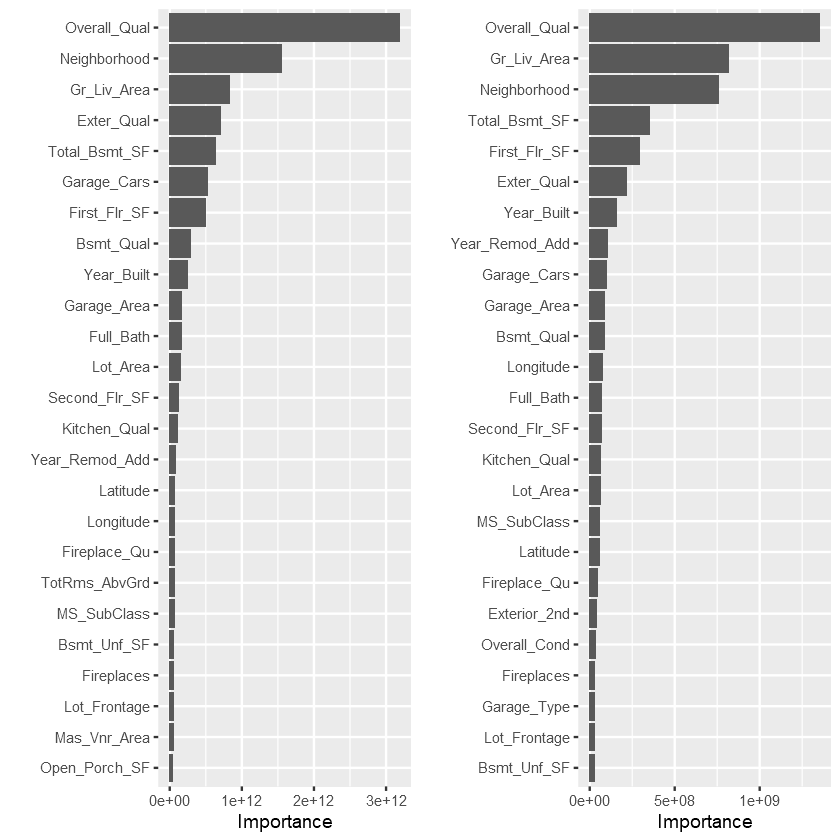

In [82]:
p1 <- vip::vip(rf_impurity, num_features = 25, bar = FALSE)
p2 <- vip::vip(rf_permutation, num_features = 25, bar = FALSE)

gridExtra::grid.arrange(p1, p2, nrow = 1)